In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import os
from datetime import datetime
from sklearn.metrics import mean_squared_error

In [2]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
wti_resid = pd.read_csv('data_output_auto/WTI拟合残差_2024后预测.csv', parse_dates=['Date'], index_col=False)
# 将日期设为索引
wti_resid.set_index('Date', inplace=True)
wti_resid = wti_resid.resample('ME').last()
wti_resid.reset_index(inplace=True)
wti_resid.tail()

,Date,WTI原油期货价格拟合残差/WTI连1-连4月差/标准差剔除异常值
17,2025-06-30,-7.240872
18,2025-07-31,-8.318296
19,2025-08-31,-6.603626
20,2025-09-30,-5.705528
21,2025-10-31,-5.494774


In [5]:
wti_1_4 = pd.ExcelFile('eta/WTI连1-连4月差_月度数据.xlsx').parse('Sheet1')
wti_1_4['Date'] = pd.to_datetime(wti_1_4['Date'], errors='coerce')
wti_1_4 = wti_1_4.sort_values('Date', ascending=True)
wti_1_4 = wti_1_4.drop(columns=['真实值'])
wti_1_4 = wti_1_4.dropna()
wti_1_4 = wti_1_4.rename(columns={'预测值':'WTI连1-连4月差'})
wti_1_4.tail()

,Date,WTI连1-连4月差
5,2025-07-31,2.6560
4,2025-08-31,1.5755
3,2025-09-30,0.7587
2,2025-10-31,0.9087
1,2025-11-30,1.6544


In [6]:
# 假设你有四个 DataFrame
dataframes = [wti_resid, wti_1_4]   
# 使用 reduce 和 pd.merge 合并
merged_df = reduce(lambda left, right: pd.merge(left, right, on='Date', how='inner'), dataframes)
merged_df.tail()

,Date,WTI原油期货价格拟合残差/WTI连1-连4月差/标准差剔除异常值,WTI连1-连4月差
8,2025-06-30,-7.240872,3.1980
9,2025-07-31,-8.318296,2.6560
10,2025-08-31,-6.603626,1.5755
11,2025-09-30,-5.705528,0.7587
12,2025-10-31,-5.494774,0.9087


In [7]:
merged_df['WTI原油期货价格预测'] =  4.3141 * (merged_df['WTI连1-连4月差']) + 71.6895 + merged_df['WTI原油期货价格拟合残差/WTI连1-连4月差/标准差剔除异常值'] 

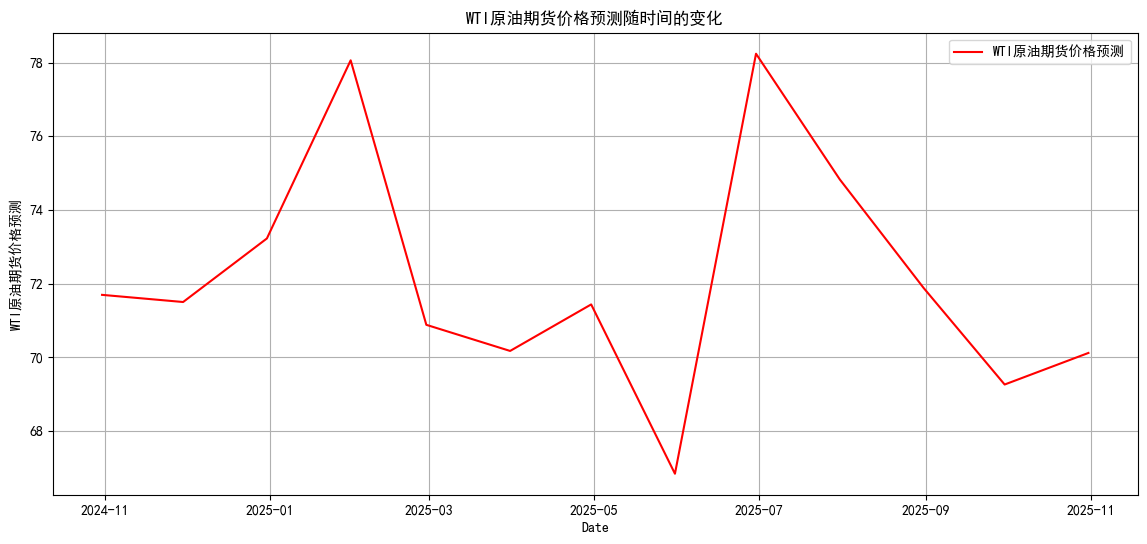

In [8]:
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False 

plt.figure(figsize=(14, 6))
plt.plot(merged_df['Date'], merged_df['WTI原油期货价格预测'], label='WTI原油期货价格预测', color='red')
plt.xlabel('Date')
plt.ylabel('WTI原油期货价格预测')
plt.title('WTI原油期货价格预测随时间的变化')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
file_path_wti = 'data_input_auto/wti原油期货价格.xlsx'
wti = pd.read_excel(file_path_wti, sheet_name='Sheet1', names=['Date', 'wti原油期货价格'])
wti['Date'] = pd.to_datetime(wti['Date'], errors='coerce')
wti = wti[wti['Date'] >= '2023-01-01']
wti.set_index('Date', inplace=True)
wti.tail()

,wti原油期货价格
Date,
2025-10-20,56.93
2025-10-21,57.58
2025-10-22,59.38
2025-10-23,61.75
2025-10-24,61.44


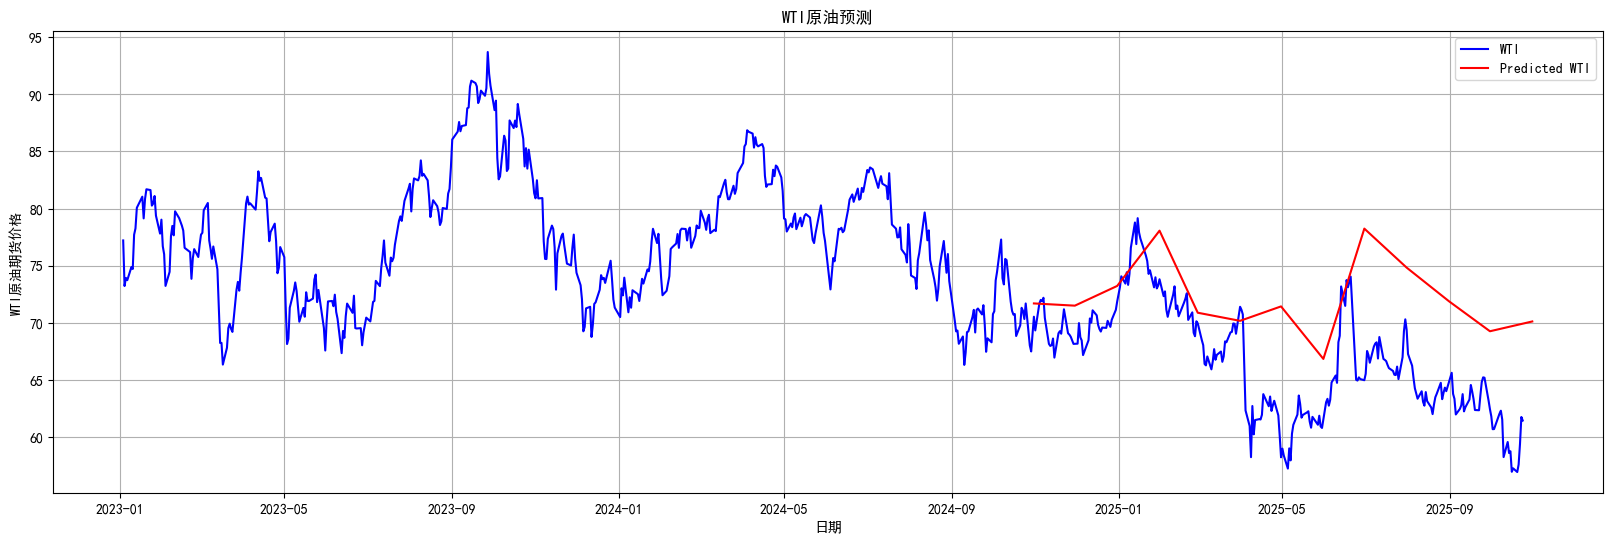

In [10]:
plt.figure(figsize=(20, 6))
plt.plot(wti.index, wti['wti原油期货价格'], label='WTI', color='blue')
plt.plot(merged_df['Date'], merged_df['WTI原油期货价格预测'], label='Predicted WTI', color='red')


plt.title('WTI原油预测')
plt.xlabel('日期')
plt.ylabel('WTI原油期货价格')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
result = merged_df[['Date','WTI原油期货价格预测']]
result.tail()

,Date,WTI原油期货价格预测
8,2025-06-30,78.245120
9,2025-07-31,74.829454
10,2025-08-31,71.882739
11,2025-09-30,69.257079
12,2025-10-31,70.114949


---

In [12]:
file_path_wti = 'data_output_auto/wti原油期货价格预测2.xlsx'
wti_predict_1 = pd.read_excel(file_path_wti, sheet_name='Sheet1')
wti_predict_1['Date'] = pd.to_datetime(wti_predict_1['Date'])
wti_predict_1 = wti_predict_1.resample('ME', on='Date').mean().reset_index()
wti_predict_1

,Date,WTI原油期货价格预测
0,2025-10-31,60.473005
1,2025-11-30,52.552120


In [13]:
# 先将result和wti_predict_1按Date合并,如果有重复的Date则使用wti_predict_1的值
merged_result = pd.concat([wti_predict_1, result]).drop_duplicates(subset='Date', keep='first')
merged_result = merged_result.sort_values(by='Date').reset_index(drop=True)

monthly_result =  merged_result.sort_values('Date', ascending=False)
output_excel_file = 'data_output_auto/WTI原油期货价格_预测_月度均值.xlsx'
monthly_result.to_excel(output_excel_file, index=False)
monthly_result

,Date,WTI原油期货价格预测
13,2025-11-30,52.552120
12,2025-10-31,60.473005
11,2025-09-30,69.257079
10,2025-08-31,71.882739
9,2025-07-31,74.829454
8,2025-06-30,78.245120
7,2025-05-31,66.833446
6,2025-04-30,71.433317
5,2025-03-31,70.169424
4,2025-02-28,70.879169


---

In [14]:
# 将wti转换为月度数据
wti_monthly = wti.resample('ME').mean()
wti_monthly = wti_monthly.reset_index()
wti_monthly_real_and_prediction = pd.merge(wti_monthly, monthly_result, on='Date', how='outer')
wti_monthly_real_and_prediction = wti_monthly_real_and_prediction.sort_values('Date', ascending=False)
# 将日期格式转换为年/月/日格式
wti_monthly_real_and_prediction['Date'] = wti_monthly_real_and_prediction['Date'].dt.strftime('%Y/%m/%d')   
wti_monthly_real_and_prediction.to_excel('eta/wti_月度数据.xlsx', index=False, float_format='%.2f')
wti_monthly_real_and_prediction.head()

,Date,wti原油期货价格,WTI原油期货价格预测
34,2025/11/30,NaN,52.552120
33,2025/10/31,59.842778,60.473005
32,2025/09/30,63.467143,69.257079
31,2025/08/31,63.900476,71.882739
30,2025/07/31,67.090435,74.829454


---

In [15]:
from Lcel import update_excel_data
file_path = "eta/1.WTI_数据上传.xlsx"
sheet_name = "详情页"
identifier = "WTI原油期货价格"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(wti_monthly_real_and_prediction, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

数据过滤完成: 保留 23 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/10/31, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件
